# Rapport de TP : Attaque par Analyse de Correlation Électromagnetique

- *Cours*: ISMIN, "Théorie et pratique des attaques par observation"
- *Année*: 2023
- *Auteurs*: [Arsene Baert](arsene.baert@etu.emse.fr) et [Michely PEREIRA](michelly.pereira@etu.emse.fr)

## 1. Introduction
Les attaques par canaux cachés sont une catégorie d'attaques de sécurité cryptographique qui exploitent les informations non intentionnelles divulguées par un dispositif lors du traitement d'informations secrètes. Ces attaques peuvent être basées sur des mesures de la consommation de la cible, par exemple l'analyse de puissance (consommation) de corrélation (CPA) sur [1], de courant, de signal électromagnétique et d'autres signaux physiques produits par l'appareil lorsqu'il traite une information.

Dans ce TP, notre attaque est basée sur les mesures et analyses statistiques du rayonnement électromagnétique (EM) en mode boîte blanche dans le contexte de la "Correlation Eletro-Magnetic Analysis" (CEMA), une technique de canaux cachés qui utilise lesdites mesures de rayonnement pour identifier des informations secrètes. Dans le cas de la CEMA, l'attaquant collecte les mesures électromagnétiques de l'appareil pendant le traitement cryptographique et les analyses pour identifier les corrélations entre les mesures et des hypothèses sur les données secrètes. Ces corrélations seront ensuite utilisées pour déduire la clé cryptographique d'un AES.

L'AES (Advanced Encryption Standard) est un algorithme de cryptage à clé symétrique considéré comme sécurisé et utilisé dans de nombreuses applications, par exemple dans le protocole de sécurité Wi-Fi. Le chiffrement symétrique est basé sur une seule clé secrète qui est utilisée à la fois pour chiffrer et déchiffrer les données. Cette clé doit donc être très bien protégée et ne pas tomber entre de mauvaises mains. Le processus de cryptage AES est illustré ci-dessous, où l'on voit les 4 opérations élémentaires : AddRoundKey, SubBytes, ShiftRows et MixColumns. 

<img src="Figures/aes.png"  width="500">

**Figure 1** - AES Encryption Process

La cible de notre attaque sera une puce de type STM32F10x présente sur une carte STM32VLDISCOVERY.

![STM32VLDISCOVERY](Figures/STM32VLDISCOVERY.png)

**Figure 2** - STM32VLDISCOVERY

Dans ce contexte, notre objectif sera de trouver la valeur de la clé d'un AES en utilisant la méthode CEMA expliquée ci-dessus et avec les outils logiciels et matériels fournis. Une fois l'attaque réussie, nous mettrons en place une première contre-mesure par désynchronisation, décalage volontaire du défenseur des traces, que nous allons, ensuite, mettre en défaut. Finalement, nous présenterons succinctement d'autres stratégies de défense disponibles.

## 2. Méthodologie

Notre méthodologie est composée de 4 étapes : l'acquisition et le traitement du signal électromagnétique, l'attaque pour récupérer la valeur de chaque octet de la clé de l'AES, le développement d'une contre-mesure qui consiste à désynchroniser l'onde analysée et enfin le test fonctionnel de cette contre-mesure, où nous vérifierons si nous pouvons toujours trouver la valeur de la clé.

![Methodologie](Figures/methodologie.png)
**Figure 3** - Methodologie suivie

## 3. Acquisition des traces
### 3.1. Matériel et montage
Comme dit précedemment, notre cible est une puce de type STM32F10x présente sur une carte STM32VLDISCOVERY. On communique en UART avec la cible sur les pin PA9 (Tx) et PA10 (Rx) à l'aide d'un module PmodUSBUART. Le logiciel *codeBlocks* est utilisé et permet d'envoyer les textes non chiffrés et de recevoir les réponses de la STM grâce à l'interface UART. De plus, on se connecte au Pin PB8 pour avoir un trigger dont on discutera par la suite.

On capte les signaux électro-magnétiques émis par la cible à l'aide d'une sonde EM placée sur une potence. La potence permet de garder la sonde dans une position stable et de positionner la sonde précisément au-dessus de la cible. Le signal de la sonde est amplifié à l'aide d'un préamplificateur *Langer EMV PA 306 SMA*.

Le signal du trigger et de la sonde est capturé par un *picoscope* connecté à notre pc et nous permettant de visualiser les signaux.

<img src="Figures/cible.jpg"  width="600">

**Figure 4** - Cible

### 3.2. Choix de la fenêtre d'intérêt
La fenêtre d'intérêt représente notre paramètre temporel. Il est primordial de bien paramétrer celle-ci, car de toute l’activité de la cible que l’on est capable d’observer, seules certaines parties présentent un intérêt. Hors notre fenêtre d'observation est limitée par la mémoire que l'on lui alloue et est dépendante de la fréquence d'échantillonnage choisie. Plus la fréquence d'échantillonnage est grande, plus petite est notre fenêtre d'observation. On précise qu'il est nécessaire de respecter le théorème de Shannon et ainsi avoir une fréquence d'échantillonnage 2 fois supérieure à la fréquence de ce que l'on veut observer. Ici, la fréquence de référence est celle de fonctionnement de la cible.

Au moment de l'acquisition des traces, il faut identifier notre fenêtre d'intérêt dans le code AES embarqué. Dans notre cas, nous voulons que dependant de l'entrée, les plainTexts, nous ayons la plus grande variabilité possible. C'est pour cette raison que nous avons choisi le premier round de la fonction SubBytes pour notre fenêtre d'observation. Nous ajoutons donc une condition if et activons et désactivons le trigger au point d'intérêt, on précise que cela est bien évidemment possible, car nous sommes en boîte blanche. Le signal de trigger nous permet d'obtenir notre paramètre temporel et aussi de calibrer notre fenêtre d'observation.

Ci-dessous, la fonction AES_Run avec les modifications :


```C
void AES_Run(void)
{
	int i;

	addRoundKey();	
	for(i = 0; i < 9; i++)
	{
		if (i == 0)  // Sur le premier SubBytes
		{
		    GPIO_SetBits(GPIOB, GPIO_Pin_8);  // Début du trigger
		    subBytes();
		    GPIO_ResetBits(GPIOB, GPIO_Pin_8);  // Fin du trigger
	    }
		else 
			subBytes();			
	    shiftRows();
	    mixColumns();
		computeKey(rcon[i]);
		addRoundKey();
	}
	
	
	subBytes();
	shiftRows();
	computeKey(rcon[i]);
	addRoundKey();
}

```

On fait une première capture nous permettant de nous assurer de l'activation et désactivation de notre trigger en rouge :

<img src="Figures/Trigger%20without%20trace.jpg"  width="600">

**Figure 5** - Trigger sans la sonde

Ensuite, le signal EM peut être observé en branchant la sonde EM en bleu:

<img src="Figures/trigger.png"  width="600">

**Figure 6** - Signaux de la trace en bleu et trigger en rouge

Les pics ne sont que peu visibles. On va donc chercher la meilleure position par rapport aux axes x, y, z de notre sonde en analysant les signaux EM en temps réel. Après avoir réglé notre paramètre spatial correspondant à la position de la sonde, nous réglons les paramètres de l'oscilloscope, pour avoir le plus de points dans notre fenêtre d'observation et ne pas observer de saturation sur les points d'intérêt du signal, nous avons donc les paramètres suivants :

<img src="Figures/picos.png"  width="600">
<br>
<img src="Figures/picos2.png"  width="600">

**Figure 7** - Signaux de la trace en bleu et trigger en rouge avec configuration des paramêtres sur l'oscilloscope


On capture 300 traces avec chacune 2504 points. Nous pouvons ainsi observer ci-dessous la persistance des patterns entre les exécutions de chaque trace.

<img src="Figures/persistance.png"  width="600">

**Figure 8** - La persistance des signaux

Des paternes répétitif se dévoile sur le signal sous forme de 32 pics distincts. On sait que l'on fait 3 opérations par octets :
- load
- operation
- store
On observe uniquement 32 pics (2x16) car l'opération émet un rayonnement plus faible moins distinct que le load ou le store. En effet, les appels mémoires provoquent plus d'émission EM, car l'on sort du processeur provoquant une plus forte consommation et ainsi plus d'émissions EM.

On enregistre nos 300 traces au sein de fichiers csv. Un fichier correspond à une trace.
Après le processus d'acquisition des traces, nous avons effectué une petite phase de prétraitement des données pour supprimer les caractères spéciaux que l'oscilloscope générait lors de la capture des signaux.


## 4. Attaque CEMA
### 4.1. Présentation théorique

Une fois que les traces sont récupérés, traités et stockés, nous passons à la phase de construction de nos hypothèses de clés. Pour cela, nous utilisons l'algorithme présenté dans la figure ci-dessous, où on calcule le XOR de chaque hypothèse d'octet de clé (0 à 255) avec un octet de chacun des 300 messages prises (les textes en clair). Le résultat de chacune de ces opérations est passé par une Sbox et finalement on calcule le poids de Hamming (Hamming Weight) qui compte le nombre de 1 dans la donnée. La dernière partie de l'algorithme consiste à calculer la corrélation entre le poids de Hamming et la matrice de traces. Nous trouvons ainsi le coefficient de
corrélation le plus élevé pour une hypothèse, cette hypothèse sera donc l'octet de notre clé avec le plus de probabilité. Ce processus est reproduit
pour chaque octet de la clé.

<img src="Figures/operation.png"  width="450">

**Figure 9** - Operations

### 4.2. Implémentation
#### Import des bibliothèques

In [1]:
import collections

import numpy as np
import matplotlib.pyplot as plt
from utils import hamming_weight, aes_sbox


#### Chargement des Traces
On charge les traces depuis nos fichiers csv et on les stocke dans une matrice numpy.

On peut vérifier sur quelques traces qu'il n'y a pas eu de problème lors du chargement en les affichant et en les comparant les valeurs présentes dans le fichier .csv correspondant.

On vérifie aussi que la taille de la donnée chargée correspond à nos 300 traces de 2504 points.


In [3]:
# For csv
full_trace_em = np.empty((0, 2504))

for i in range(1,301):  # Repeat for our 300 traces    
    i_str = str(i)
    file_name = "./Data/Trace_csv/20230130-0001 (" + i_str  + ").csv"
    full_trace_em_str = np.loadtxt(file_name, dtype=str, delimiter=';', skiprows=3)
    full_trace_em_str = full_trace_em_str[:,1]  # The first column contain time data but is not relevant because each point is ordered by time (first point first gathered)
    full_trace_em_str = np.char.replace(full_trace_em_str, ',', '.')  # Our data collection program used comas instead of points
    full_trace_em_str = np.char.replace(full_trace_em_str, 'âˆž', '100')  # When a saturation on our data was recorded (>100mV or <100mv), it was replaced by an infinite signed, written âˆž in str, we replace it by 100
    trace_em = full_trace_em_str.astype(float)  # Transform our str type data to float
    full_trace_em = np.row_stack((full_trace_em, trace_em))

print(full_trace_em[0])
print("Taille de la matrice : ", np.shape(full_trace_em))

[ -3.949311    0.7874015  -7.898622  ...  -7.108144  -33.17852
 -29.22613  ]
Taille de la matrice :  (300, 2504)


Les traces sont ensuite enregistrées dans un fichier nommé data_em.npy. Cela nous évite de devoir les recharger depuis les fichiers csv entre deux sessions de programmation.

De plus, un utilisateur peut facilement reproduire les différentes attaques et défenses faites sur notre cible à partir des traces mesurées expérimentalement et enregistrées dans data_em.py.

In [4]:
np.save("data_em", full_trace_em)

Si les traces originales ne sont pas disponibles, on recharge les données enregistrées dans le fichier numpy :

In [5]:
full_trace_em = np.load("data_em.npy")

#### Exemple de trace
On affiche la trace numéro 29 :

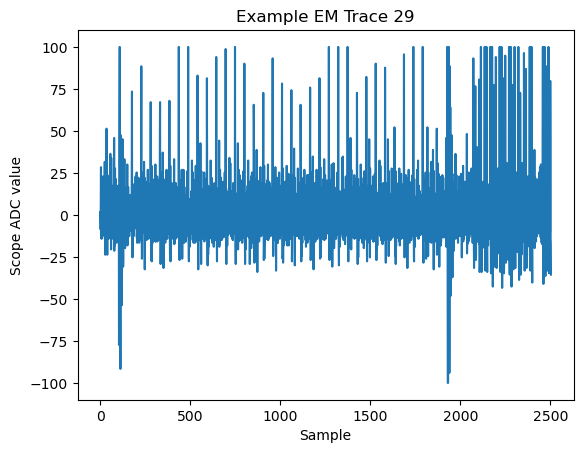

In [6]:
plt.plot(full_trace_em[29])
plt.xlabel("Sample")
plt.ylabel("Scope ADC value")
plt.title("Example EM Trace 29")
plt.savefig("./Figures/Exemple_trace_29.png")
plt.show()

![Exemple_trace_29](./Figures/Exemple_trace_29.png)

#### Chargement des plains texts
On utilisera que les 300 premiers.

In [7]:
file_name = "./Data/pText.txt"
p_texts = np.loadtxt(file_name, dtype=str)
p_texts[0][:2]
print(p_texts)
print(np.shape(p_texts))

['3633f1e7147bc067445d6b5de5677bd4' '18d46a264e121a4ba23319b52cd25370'
 'b1d67c63b5c9bc79005b59025c9748d4' ... '97388406ea5d1916380313a25ace3514'
 'b82ff45942f4a70ef5a740068b16719d' 'b0127e0fdeeb2b96acf8d60ff4210b55']
(5000,)


#### Implémentation Correlation Eletro-Magnetique Analysis
Comme expliqué précedement, notre modèle reproduit le fonctionnement de la fonction SubBytes dans AES et calcule le poids de Hamming du résultat. Il prendra en argument le premier octet du texte en clair et un octet représentant un octet de notre clé.

In [10]:
# Chargement de la sbox
SBOXFile = open("./Data/sbox_dec.txt", "r")

SBox = np.zeros(256, dtype=np.int32)

for i in range(256):
    SBox[i] = SBOXFile.readline()[:-2]

def model(p_text_byte, k_byte):
    """
    Fait le xor entre deux octets 
    """
    return hamming_weight(aes_sbox(k_byte ^ p_text_byte))

def gen_array_hm(p_text, byte_pos):
    hyp_array = np.zeros((256, 300), dtype=int)
    for i in range(256):
        for j in range(300):
            hyp_array[i][j] = model(int(p_text[j][byte_pos * 2: (byte_pos + 1)  * 2], 16), i)
    return hyp_array

def gen_arra_corr(hyp_array, data_em):
    correlation_array = np.empty((256, 2504))
    for i in range(256):
        for j in range(2504):
            correlation_array[i, j] = np.corrcoef(hyp_array[i], data_em[:,j])[0, 1]
    return correlation_array

def get_max_pos(array):
    max = 0
    for i in range(np.shape(array)[0]):
        for j in range(np.shape(array)[1]):
            if (max < abs(array[i,j])):
                max = abs(array[i,j])
                max_pos = i
    return max_pos
    
def find_first_byte_key(p_texts, data_em):
    hm_array = gen_array_hm(p_texts, 0)
    corr_array = gen_arra_corr(hm_array, data_em)
    return get_max_pos(corr_array)

def find_key(p_texts, data_em):
    key = np.empty((16), dtype=int)
    for i in range(16):
        hm_array = gen_array_hm(p_texts, i)
        corr_array = gen_arra_corr(hm_array, data_em)
        key[i] = get_max_pos(corr_array)
    return key

**Explication !!!**
On affiche la corrélation pour un octet de la clef.

C:\Users\arsen\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\arsen\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


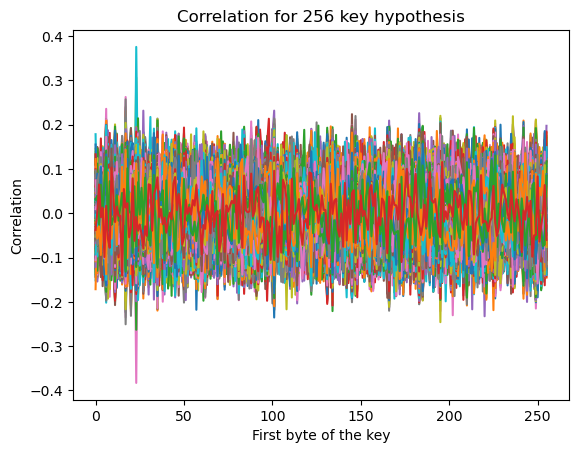

In [33]:
hm_array = gen_array_hm(p_texts, 0)
corr_array = gen_arra_corr(hm_array, full_trace_em)

plt.plot(corr_array)
plt.title(f"Correlation for 256 key hypothesis")
plt.xlabel("First byte of the key")
plt.ylabel("Correlation")
plt.show()

Après une attaque CEMA, on est capabalbe de trouver la clef :

In [49]:
key = find_key(p_texts, full_trace_em)
print(key)

[ 23 158  72  22  40 174 210 166 171 247  21 136   9 207  79  60]


**Faire le tableau !!!!**

### Mise en place de défense

- [ ] mask
- [ ] pagaging 
#### Désynchronisation
If we do desynchronisation -> time of execution change -> attacker knows there is desynchronisation -> resynchronize
To prevent the time from changing we desynchronise -> the calcul is always done in one chunck
Insert factice calcul that emits the same amount of em between different steps
Compilation dynamique : Objectif créer de l'aléatoire 
- On fait une fonction qui calcul des choses différentes de manière aléatoire mais obtient toujours le même résultat

We need to randomize the shift

In [11]:
import random

We desynchronize our data by shifting it.

In [39]:
def desync_data(data_em, nb_data_shifted, size_shift):
    data_em_desync = np.empty((300, 2504))  # Création d'une matrice
    shift_avg = 0
    for i in range(nb_data_shifted):
        nb_shift = random.randint(0, size_shift)
        shift_avg += nb_shift
        data_em_desync[i] = np.roll(data_em[i], nb_shift)
    data_em_desync[nb_data_shifted:,:] = data_em[nb_data_shifted:,:]  # Copie du reste des données sans les avoirs shiftée
    return data_em_desync, shift_avg/nb_data_shifted

Deux traces, une brut et une desynchornisée, sont affichés pour constater le décalage :
On fait différent tests pour déterminer de manière empirique quel est le décalage minimum pour avoir un facteur de corrélation faible

Shift moyen 25.2


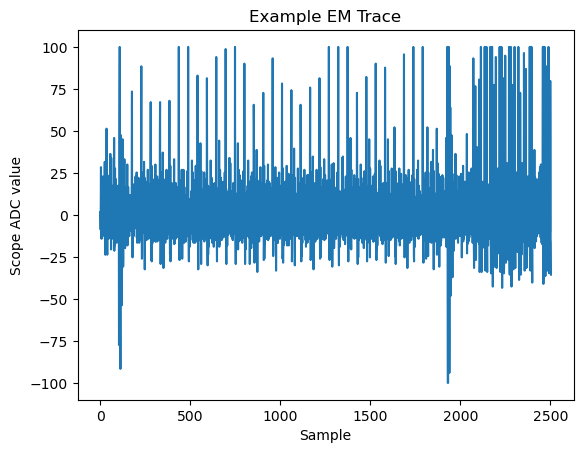

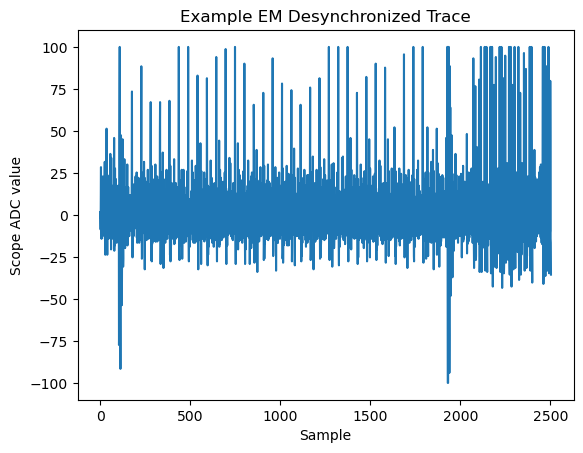

In [41]:
data_em_desync, avg_shift = desync_data(full_trace_em, 5, 50)

print("Shift moyen", avg_shift)

plt.plot(full_trace_em[29])
plt.xlabel("Sample")
plt.ylabel("Scope ADC value")
plt.title("Example EM Trace")
plt.show()

plt.plot(data_em_desync[29])
plt.xlabel("Sample")
plt.ylabel("Scope ADC value")
plt.title("Example EM Desynchronized Trace")
plt.show()

Next, we verify that our desynchronisation is enough by looking at the correlation coefficient for each hypotetical byte.
Des tests empiriques 

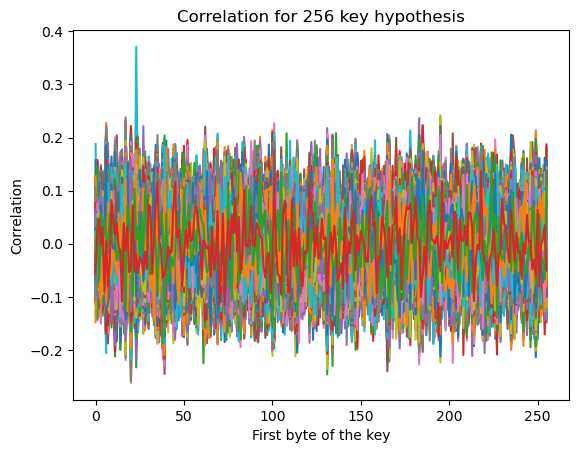

In [38]:
hm_array = gen_array_hm(p_texts, 0)
corr_array_desync = gen_arra_corr(hm_array, data_em_desync)

plt.plot(corr_array_desync)
plt.title(f"Correlation for 256 key hypothesis")
plt.xlabel("First byte of the key")
plt.ylabel("Correlation")
plt.show()

**150, 50**

Shift moyen :  26.166666666666668


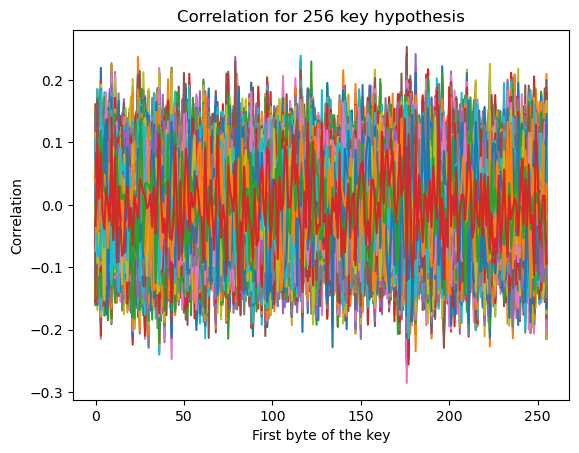

In [43]:
data_em_desync, shift_avg = desync_data(full_trace_em, 150, 50)

print("Shift moyen : ", shift_avg)

hm_array = gen_array_hm(p_texts, 0)
corr_array_desync = gen_arra_corr(hm_array, data_em_desync)

plt.plot(corr_array_desync)
plt.title(f"Correlation for 256 key hypothesis")
plt.xlabel("First byte of the key")
plt.ylabel("Correlation")
plt.show()

We can observe that there is no more peak for the byte 23. Our desynchronisation worked.
The number of desynchronised traces and nb of shift can be changed in order to find the minimal parameters necessary to "hide" the byt of the key.


50, 50

Shift moyen :  22.5


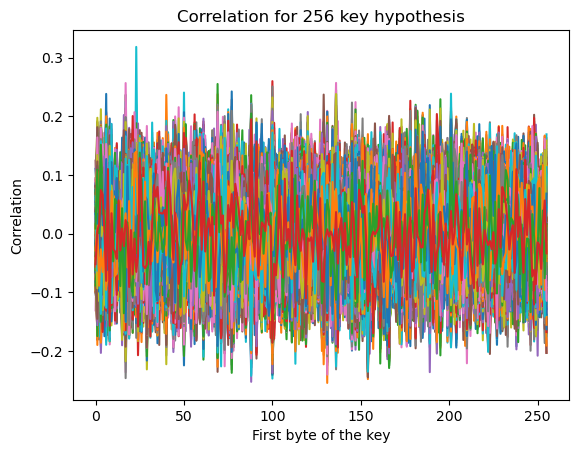

In [44]:
data_em_desync, shift_avg = desync_data(full_trace_em, 50, 50)

print("Shift moyen : ", shift_avg)

hm_array = gen_array_hm(p_texts, 0)
corr_array_desync = gen_arra_corr(hm_array, data_em_desync)

plt.plot(corr_array_desync)
plt.title(f"Correlation for 256 key hypothesis")
plt.xlabel("First byte of the key")
plt.ylabel("Correlation")
plt.show()

In [45]:
print(get_max_pos(corr_array_desync))

23


Shift moyen :  26.0125


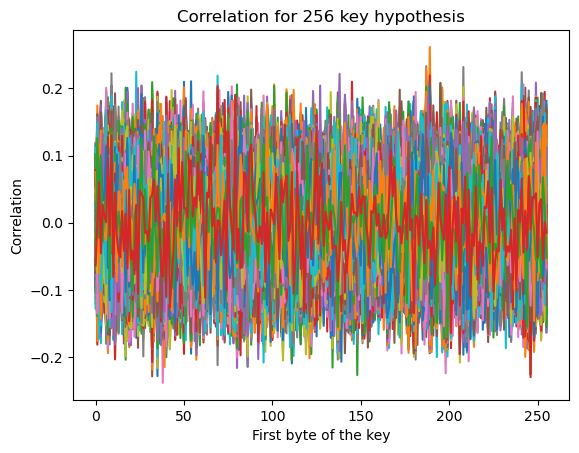

In [46]:
data_em_desync, shift_avg = desync_data(full_trace_em, 80, 50)

print("Shift moyen : ", shift_avg)

hm_array = gen_array_hm(p_texts, 0)
corr_array_desync = gen_arra_corr(hm_array, data_em_desync)

plt.plot(corr_array_desync)
plt.title(f"Correlation for 256 key hypothesis")
plt.xlabel("First byte of the key")
plt.ylabel("Correlation")
plt.show()

### Attack : resynchronisation
On resynchronise les données, on prend 

In [89]:
import tqdm

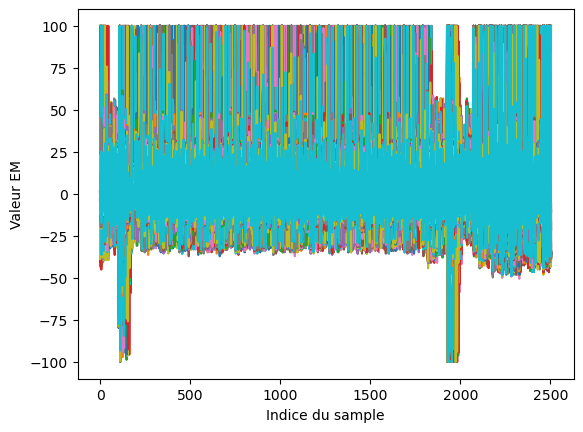

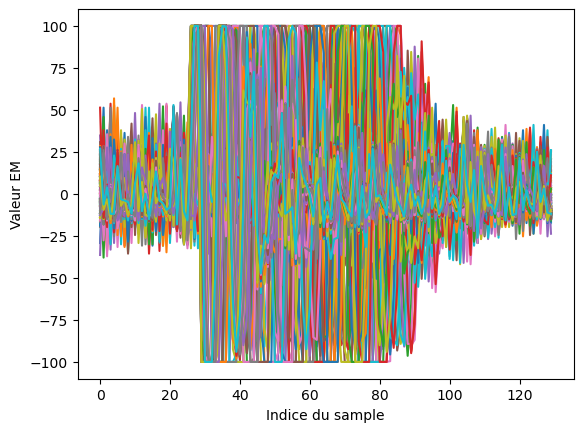

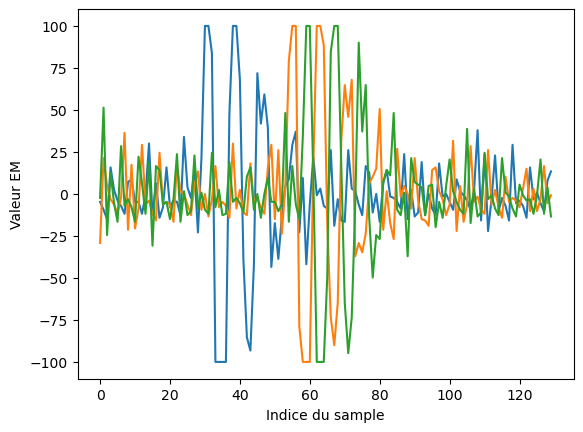

In [69]:
for i in range(300):
    plt.plot(data_em_desync[i])
plt.xlabel("Indice du sample")
plt.ylabel("Valeur EM")
plt.show()

samp_i_start = 1900
samp_i_end = 2030

for i in range(300):
    reference_pattern = data_em_desync[i, samp_i_start:pattern_end]
    plt.plot(samp_i_end)
plt.xlabel("Indice du sample")
plt.ylabel("Valeur EM")
plt.show()

for i in range(3):
    reference_pattern = data_em_desync[10 * i, samp_i_start:pattern_end]
    plt.plot(samp_i_end)
plt.xlabel("Indice du sample")
plt.ylabel("Valeur EM")
plt.show()

On observe qu'à la fin de la trace se trouve un pic significatif et présent sur toutes les traces aux alentours de 1900-2000.

On observe que ce signal est composé de 3 pics succesifs. On va utiliser cette correspondance entre les signaux pour réaligner les traces.

Pour cela on vient isoler notre paterne sur un signal :

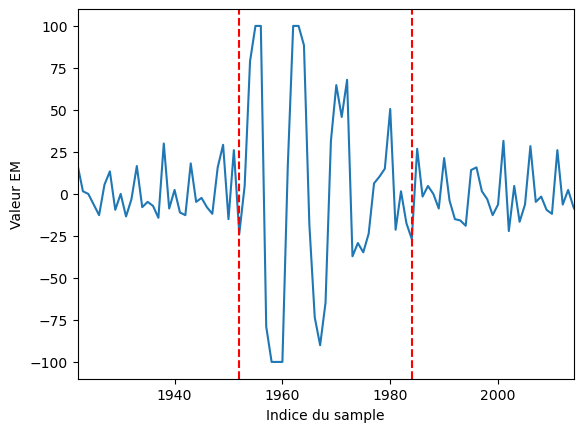

In [87]:
trace_id = 10
pattern_start = 1952
pattern_end = 1984

plt.plot(data_em_desync[trace_id])
plt.axvline(pattern_start, color="r", linestyle="--")
plt.axvline(pattern_end, color="r", linestyle="--")
plt.xlim(pattern_start - 30, pattern_end + 30)
plt.xlabel("Indice du sample")
plt.ylabel("Valeur EM")
plt.show()

reference_pattern = data_em_desync[trace_id, pattern_start:pattern_end]


On cherche ensuite la corrélation entre notre paterne et chaque trace

In [91]:
pattern_correlation = []
for i in tqdm.trange(data_em_desync.shape[0]):
    pattern_correlation.append(np.correlate(data_em_desync[i], reference_pattern))
pattern_correlation = np.array(pattern_correlation)

100%|██████████| 300/300 [00:00<00:00, 3853.97it/s]


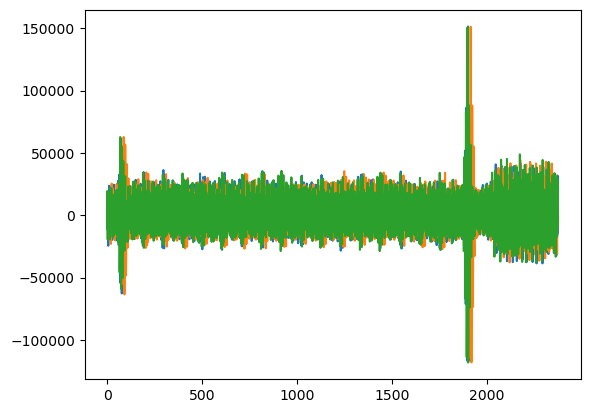

In [92]:
plt.plot(pattern_correlation[:3].T)
plt.show()

In [93]:
best_offsets = []
for i in tqdm.trange(pattern_correlation.shape[0]):
    best_offsets.append(np.argmax(pattern_correlation[i]))
best_offsets = np.array(best_offsets, dtype=np.int32)

100%|██████████| 300/300 [00:00<00:00, 7709.60it/s]


In [95]:
data_em_resync = np.zeros_like(data_em_desync)
for i in tqdm.trange(data_em_desync.shape[0]):
    shift = np.argmax(pattern_correlation[i])
    data_em_resync[i] = np.roll(data_em_desync[i], -shift)

100%|██████████| 300/300 [00:00<00:00, 17649.08it/s]


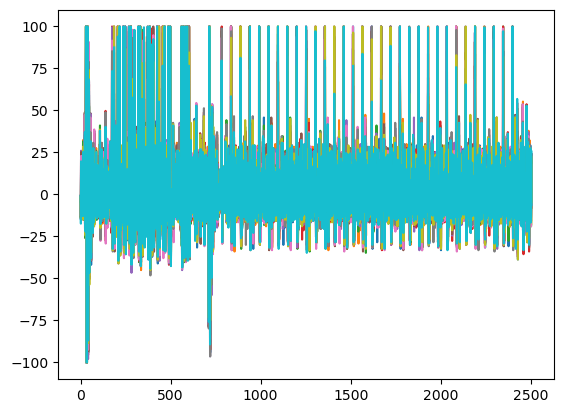

In [96]:
plt.plot(data_em_resync[:10].T)
plt.show()

On refait notre attaque :

C:\Users\arsen\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\arsen\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


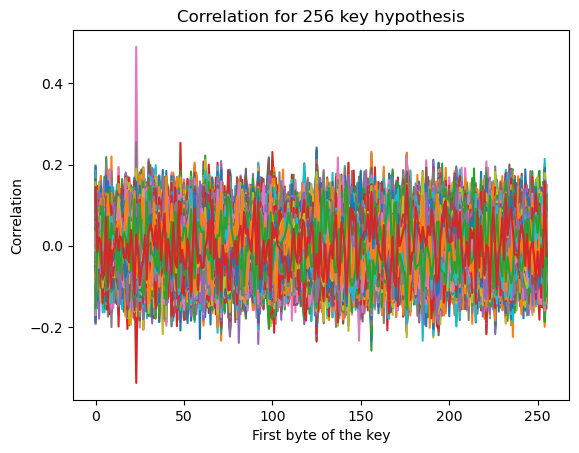

In [97]:
hm_array = gen_array_hm(p_texts, 0)
corr_array_resync = gen_arra_corr(hm_array, data_em_resync)

plt.plot(corr_array_resync)
plt.title(f"Correlation for 256 key hypothesis")
plt.xlabel("First byte of the key")
plt.ylabel("Correlation")
plt.show()

On retrouve bien notre valeur de clef

In [99]:
print(get_max_pos(corr_array_resync))

23


### Mask

### Noise augmentation

### Packaging
ChaXa : blindage féromagnétique (pas électriquement conducteur mais magnétiquement conducteur)
On vient faire une pulvérisation de la férite au dessu du circuit et mettre d'un coté une borne d'emission et de l'autre une borne de reception, les données sont collecté et traité par la puce.
Permet d'atténuer les émissions (couche de ferrite) et d'avoir une supervision (écoute, on détecte qu'il y a une sonde à cause de sa férite)